# Importation de fonctions and clases from cookie_clusters

In [16]:
from cookie_clusters import *

# Trying the algo over some selected pixels

### Creation of the data_set

In [2]:
import os
import cv2
from PIL import Image
import rasterio as rio
import re
import matplotlib.pyplot as plt

In [3]:
# List and dict of target pixels
pixels_de_interet, dic_de_pixels = create_dic_pixels()


In [4]:
pixels_de_interet[-1]

[386, 504]

## On divise les images Sentinel 2A et 2B et on les mets en ordre cronologique

In [5]:
dir = "../../ressources/images"
images_list = os.listdir(dir)

images_2A = list()
images_2B = list()
prog = re.compile(r'\w+2A')
for image in images_list:
    if prog.match(image):
        images_2A.append(image)
    else:
        images_2B.append(image)
        
images_2A.sort()
images_2B.sort()
all_images = images_2A + images_2B
all_images = sorted(all_images, key=lambda date: date[16:24])      

In [6]:
# Hero you can chose the list of images you want to use.
list_to_use = all_images
line = 0
matrice_rouge = np.zeros((len(pixels_de_interet), len(list_to_use)))
matrice_vert = np.zeros((len(pixels_de_interet), len(list_to_use)))
matrice_bleu = np.zeros((len(pixels_de_interet), len(list_to_use)))
matrice_nir = np.zeros((len(pixels_de_interet), len(list_to_use)))
for image in list_to_use:
    with rio.open(dir+'/'+image, 'r') as ds:
        band1 = ds.read(1)
        band2 = ds.read(2)
        band3 = ds.read(3)
        band4 = ds.read(4)
    # Extraction of target pixels
    for pixel,j in zip(pixels_de_interet, range(len(pixels_de_interet))):
        matrice_vert[j,line] = band3[pixel[0], pixel[1]]
        matrice_rouge[j,line] = band2[pixel[0], pixel[1]]
        matrice_bleu[j,line] = band4[pixel[0], pixel[1]]
        matrice_nir[j,line] = band1[pixel[0], pixel[1]]
    line +=1
        

(54, 141)


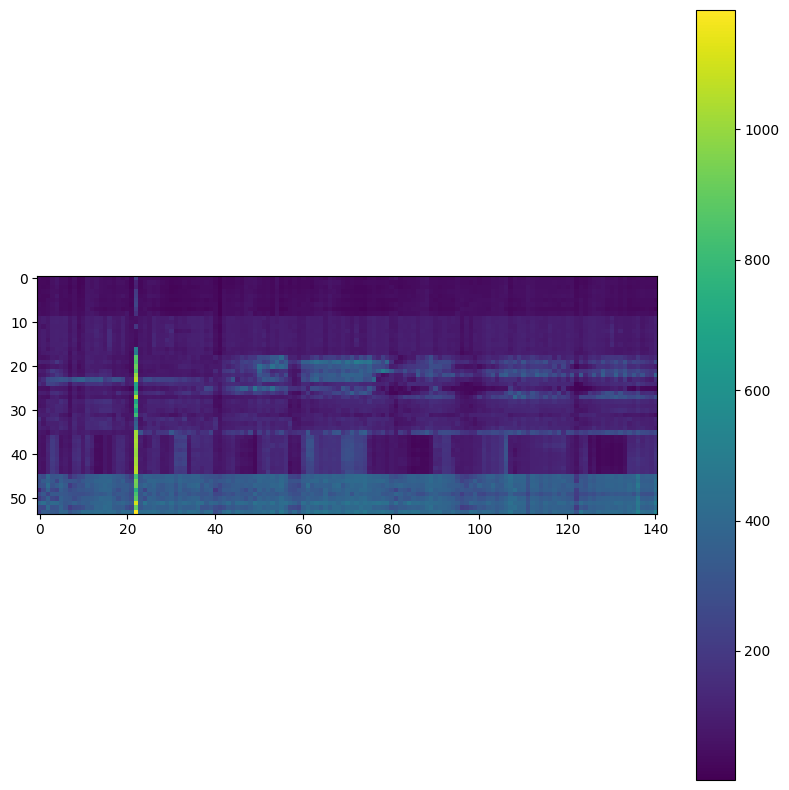

In [7]:
print(matrice_vert.shape)
#Looking for a pixels
img = (matrice_vert/8).astype(int)
#grayImage = cv2.cvtColor(uint_img, cv2.COLOR_GRAY2BGR)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.colorbar()
plt.show()


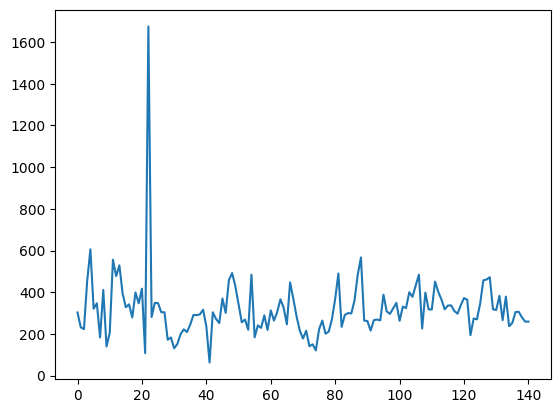

In [8]:
# L'image x est bizarre
plt.plot(matrice_vert[0])

In [9]:
chelou = np.argmax(matrice_vert[0])
chelou

22

In [10]:
matrice = np.delete(matrice_vert,chelou,1)

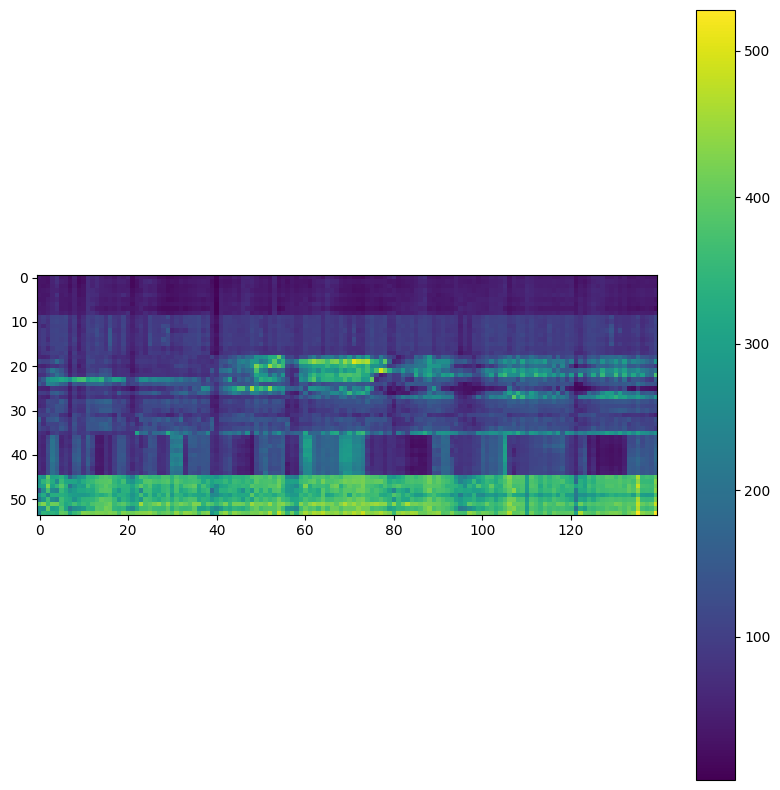

In [11]:
#Looking for a pixels
img = (matrice/8).astype(int)
#grayImage = cv2.cvtColor(uint_img, cv2.COLOR_GRAY2BGR)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.colorbar()
plt.show()


In [12]:
yhat = kmeans_dtw(matrice,6,5000)

## A simple function to show the obtained results

keys for the classes :

0: 'pix_foret'.

1: 'pix_lac'.

2: 'pix_apt'.

3: 'pix_ensta'.

4: 'pix_agri'.

5: 'pix_danone'.


0.6111111111111112

69.46854081475117

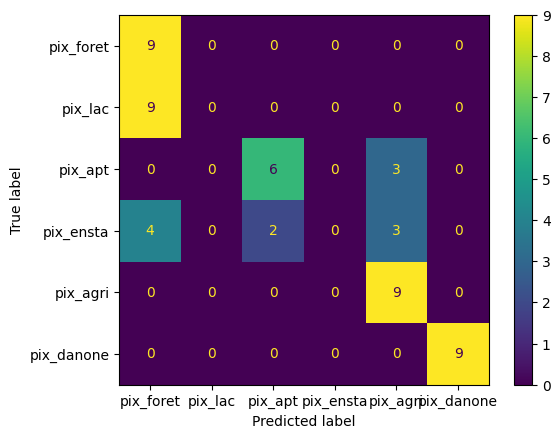

In [13]:
eval_bandevert = evaluator_de_experiences(yhat, pixels_de_interet, dic_de_pixels, matrice)
eval_bandevert.confusion_matrix()
display(eval_bandevert.metrics_classif())
display(eval_bandevert.metrics_clustering())

In [ ]:
def affichage(yhat, pix_interet):
    name = ''
    dico = collections.Counter(yhat)
    for key in list(dico.keys()):
        dico[key] = [f'number of vectors = {dico[key]}'] 
        for index,pos in zip(yhat,range(len(yhat))):
            if index == key:
                if 0<=pos<=8: name = 'pix_danone'
                elif 9<=pos<=17: name = 'pix_agri'
                elif 18<=pos<=26: name = 'pix_ensta'
                elif 27<=pos<=35: name = 'pix_apt'
                elif 36<=pos<=44: name = 'pix_lac'
                elif 45<=pos<=53: name = 'pix_foret'

                dico[key].append(f'{pix_interet[pos]}:{name}')

    for key in dico:
        print(f'cluster numero {key}:\n-------------------------------')
        for part in dico[key]:
            print(f'{part}')
        print('-------------------------------')

In [ ]:
affichage(yhat,pixels_de_interet)

cluster numero 0:
-------------------------------
number of vectors = 9
[472, 570]:pix_danone
[474, 570]:pix_danone
[476, 570]:pix_danone
[478, 570]:pix_danone
[480, 570]:pix_danone
[482, 570]:pix_danone
[484, 570]:pix_danone
[486, 570]:pix_danone
[488, 570]:pix_danone
-------------------------------
cluster numero 3:
-------------------------------
number of vectors = 17
[392, 567]:pix_agri
[392, 580]:pix_agri
[401, 577]:pix_agri
[401, 567]:pix_agri
[395, 570]:pix_agri
[395, 576]:pix_agri
[397, 571]:pix_agri
[394, 598]:pix_agri
[388, 532]:pix_agri
[414, 440]:pix_ensta
[454, 627]:pix_apt
[454, 631]:pix_apt
[457, 632]:pix_apt
[459, 625]:pix_apt
[450, 641]:pix_apt
[443, 636]:pix_apt
[439, 629]:pix_apt
-------------------------------
cluster numero 5:
-------------------------------
number of vectors = 8
[405, 448]:pix_ensta
[408, 444]:pix_ensta
[412, 446]:pix_ensta
[412, 463]:pix_ensta
[407, 465]:pix_ensta
[401, 446]:pix_ensta
[447, 618]:pix_apt
[433, 617]:pix_apt
-----------------------

## En repetant la meme tache avec le NDVI

In [ ]:
list_to_use = all_images
line = 0
matrice = np.zeros((len(pixels_de_interet), len(list_to_use)))
for image in list_to_use:
    with rio.open(dir+'/'+image, 'r') as ds:
        # arr = ds.read()
        band1 = ds.read(1)
        band2 = ds.read(2)
        ndvi = (band1-band2)/(band1+band2)
        # band3 = ds.read(3)
        # band4 = ds.read(4)
    # Extraction of target pixels
    for pixel,j in zip(pixels_de_interet, range(len(pixels_de_interet))):
        matrice[j,line] = ndvi[pixel[0], pixel[1]]
    line +=1



/tmp/ipykernel_1270/3564424484.py:9: RuntimeWarning: invalid value encountered in divide
  ndvi = (band1-band2)/(band1+band2)


(54, 141)


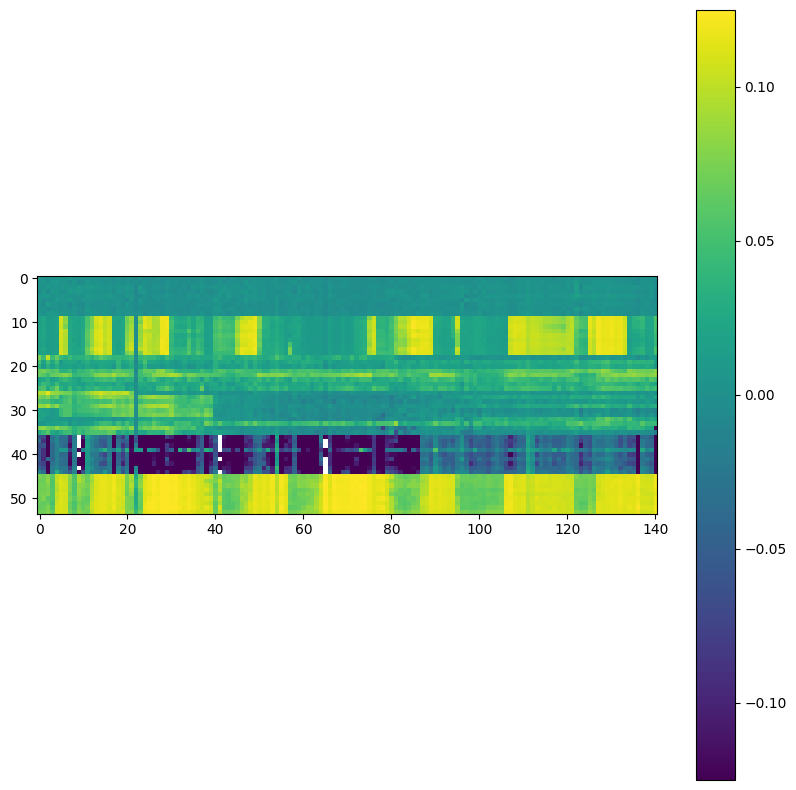

In [ ]:
print(matrice.shape)
#Looking for a pixels
img = (matrice/8)
#grayImage = cv2.cvtColor(uint_img, cv2.COLOR_GRAY2BGR)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.colorbar()
plt.show()